In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning.pytorch as pl
import torchmetrics

import torchvision.datasets as datasets
from torchvision import transforms
torch.set_float32_matmul_precision('medium')

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
device

device(type='cuda')

In [3]:
mean = [0.5071, 0.4867, 0.4408]
std = [0.2470, 0.2435, 0.2616]
train_transform = transforms.Compose([transforms.Resize((227,227)),
                                      transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                
                                
                               transforms.Normalize(mean,std)])

val_transform = transforms.Compose([transforms.Resize((227,227)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

In [4]:
class CIFAR100DataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(CIFAR100DataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def prepare_data(self):
        datasets.CIFAR100(root = self.root,train=True,download=True)
        datasets.CIFAR100(root = self.root,train=False,download=True)

    def setup(self, stage):
        train_dataset = datasets.CIFAR100(root = self.root,train=True,download=False,transform= train_transform)
        self.test_dataset =  datasets.CIFAR100(root = self.root,train=False,download=False,transform= val_transform)
        # Define the proportions for the split
        train_proportion = 0.8  # 80% for training
        val_proportion = 0.2  # 20% for validation

        # Calculate the sizes of training and validation sets based on the proportions
        train_size = int(train_proportion * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [5]:
root = "./data"
batch_size = 768
num_workers = 8
ds = CIFAR100DataLoader(root, batch_size, num_workers)

In [6]:
# # Sanity
# ds.prepare_data()
# ds.setup('valid')
# for data,label in ds.val_dataloader():
#     print(data.shape,label.shape)
#     break

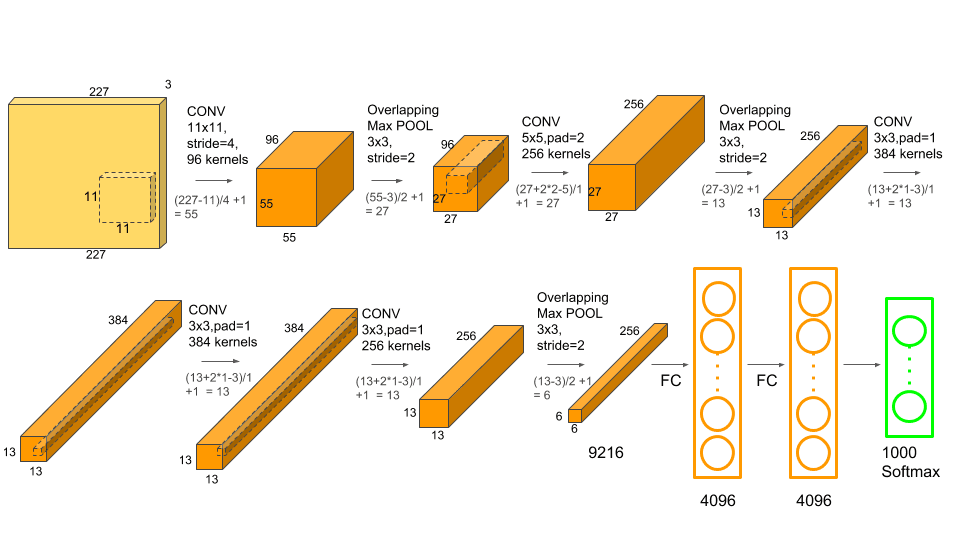

In [7]:
class AlexNet(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
                        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0),
                        nn.BatchNorm2d(96),
                        nn.ReLU(),
                      nn.MaxPool2d(kernel_size=3,stride=2),
                      
                      nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2,stride=2),

                    nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                    nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(384),
                      nn.ReLU(),

                    nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=3,stride=2),

                        nn.Flatten(),
                      
                      nn.Linear(6*6*256,4096),
                      nn.Dropout(0.2),
                      nn.SiLU(),

                    nn.Linear(4096,4096),
                      nn.Dropout(0.2),
                      nn.SiLU(),

                    nn.Linear(4096,100)
      
                         )

        self.accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=100)
        self.f1_score = torchmetrics.F1Score(task="multiclass",num_classes=100)

        self.lr = 1e-3

    def forward(self,x):
        return self.layers(x)

    def _common_step(self,batch,batch_index):
        x, y = batch
        
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat,y)
        return loss , y_hat


    def training_step(self,batch, batch_idx):
        x,y = batch
        loss , y_hat = self._common_step(batch,batch_idx)
        accuracy, f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'train_loss':loss,
                      'train_accuracy':accuracy,
                      'train_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,y = batch
        loss, y_hat = self._common_step(batch,batch_idx)
        
        accuracy,f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'val_loss':loss,
                      'val_accuracy':accuracy,
                      'val_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x,y = batch
        loss, y_hat = self._common_step(batch,batch_idx)
        
        accuracy,f1_score = self.accuracy(y_hat,y), self.f1_score(y_hat,y)
        self.log_dict({'test_loss':loss,
                      'test_accuracy':accuracy,
                      'test_f1score':f1_score},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.lr)
        

In [8]:
num_epoch =200
model = AlexNet()
logger = pl.loggers.TensorBoardLogger(save_dir='./log/', name='cifar100', version=0.2)
trainer = pl.Trainer(logger=logger, precision='bf16-mixed',max_epochs=num_epoch,enable_model_summary=True, enable_progress_bar=True,callbacks=[pl.callbacks.EarlyStopping('val_loss',patience=6,verbose=True)])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model,ds,ckpt_path="cifar100_alexnet.ckpt")

Files already downloaded and verified
Files already downloaded and verified


/home/pranav-pc/.env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory ./log/cifar100/version_0.2/checkpoints exists and is not empty.
Restoring states from the checkpoint path at cifar100_alexnet.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | layers   | Sequential         | 58.7 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | f1_score | MulticlassF1Score  | 0      | train
--------------------------------------------------------
58.7 M    Trainable params
0         Non-trainable params
58.7 M    Total params
234.775   Total estimated model params size (MB)
Restored all states from the checkpoint at cifar100_alexnet.ckpt


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 0.918


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.918. Signaling Trainer to stop.


In [10]:
trainer.validate(model, ds)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.786899983882904     │
│        val_f1score        │     0.786899983882904     │
│         val_loss          │    0.8146463632583618     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8146463632583618,
  'val_accuracy': 0.786899983882904,
  'val_f1score': 0.786899983882904}]

In [11]:
trainer.test(model,ds)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5651000142097473     │
│       test_f1score        │    0.5651000142097473     │
│         test_loss         │    1.8304110765457153     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.8304110765457153,
  'test_accuracy': 0.5651000142097473,
  'test_f1score': 0.5651000142097473}]

In [12]:
trainer.save_checkpoint("cifar100_alexnet.ckpt")